将视觉语言模型llama封装成API服务，通过agent对complex question进行解答

Plan-and-execute agents accomplish an objective by first planning what to do, then executing the sub tasks. This idea is largely inspired by [BabyAGI](https://github.com/yoheinakajima/babyagi) and then the ["Plan-and-Solve" paper](https://arxiv.org/abs/2305.04091). The planning is almost always done by an LLM. The execution is usually done by a separate agent (equipped with tools).

In [1]:
# %pip install -qU openai langchain
from langchain.chains import LLMMathChain
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain.tools import BaseTool, StructuredTool, Tool, tool
from langchain_openai import ChatOpenAI
import os
from PIL import Image
from langchain.agents import initialize_agent, AgentType
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
import sys

os.environ["HTTP_PROXY"] = "http://127.0.0.1:7890"
os.environ["HTTPS_PROXY"] = "http://127.0.0.1:7890"
OPENAI_API_KEY = "<input your api key>"


## Tools

In [2]:
import torch
import argparse
from video_llama.common.config import Config
from video_llama.common.registry import registry
from video_llama.conversation.conversation_video import Chat, default_conversation, conv_llava_llama_2
import decord
decord.bridge.set_bridge('torch')
import cv2
from video_llama.datasets.builders import *
from video_llama.models import *
from video_llama.processors import *
from video_llama.runners import *
from video_llama.tasks import *

def parse_args():
    parser = argparse.ArgumentParser(description="Demo")
    parser.add_argument("--cfg-path", default='/mnt/xuyibo/Video-LLaMA/eval_configs/video_llama_eval_withaudio.yaml', help="path to configuration file.")
    parser.add_argument("--gpu-id", type=int, default=2, help="specify the gpu to load the model.")
    parser.add_argument("--model_type", type=str, default='llama_v2', help="The type of LLM")
    parser.add_argument(
        "--options",
        nargs="+",
        help="override some settings in the used config, the key-value pair "
        "in xxx=yyy format will be merged into config file (deprecate), "
        "change to --cfg-options instead.",
    )
    args = parser.parse_args(args=[])
    return args


class ChatBot:

    def __init__(self, args):
        self.chat = self._init_model(args)
        if args.model_type == 'vicuna':
            self.chat_state = default_conversation.copy()
        else:
            self.chat_state = conv_llava_llama_2.copy()
        self.img_list = list()
        self.set_para()

    def _init_model(self, args):
        print('Initializing Chat')
        cfg = Config(args)
        model_config = cfg.model_cfg
        model_config.device_8bit = args.gpu_id
        model_cls = registry.get_model_class(model_config.arch)
        model = model_cls.from_config(model_config).to('cuda:{}'.format(args.gpu_id))
        model.eval()
        vis_processor_cfg = cfg.datasets_cfg.webvid.vis_processor.train
        vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)
        chat = Chat(model, vis_processor, device='cuda:{}'.format(args.gpu_id))
        print('Initialization Finished')
        return chat

    def set_para(self, num_beams=1, temperature=1.0):
        self.num_beams = num_beams
        self.temperature = temperature
        print('set num_beams: {}'.format(num_beams))
        print('set temperature: {}'.format(temperature))

    def upload(self, up_img=False, up_video=False, audio_flag=True):
        if up_img and not up_video:
            self.chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully, and explain your answers in detail."
            self.chat.upload_img(up_img, self.chat_state, self.img_list)
        elif not up_img and up_video:
            self.chat_state.system =  "You are able to understand the visual content that the user provides. Follow the instructions carefully, and explain your answers in detail."
            if audio_flag:
                self.chat.upload_video(up_video, self.chat_state, self.img_list)
            else:
                self.chat.upload_video_without_audio(up_video, self.chat_state, self.img_list)

    def ask_answer(self, user_message):
        self.chat.ask(user_message, self.chat_state)
        llm_message = self.chat.answer(conv=self.chat_state,
                                       img_list=self.img_list,
                                       num_beams=self.num_beams,
                                       temperature=self.temperature,
                                       max_new_tokens=300,
                                       max_length=2000)[0]

        return llm_message

    def reset(self):
        if self.chat_state is not None:
            self.chat_state.messages = list()
        if self.img_list is not None:
            self.img_list = list()
        self.set_para()

args = parse_args()
chatbot = ChatBot(args)

def video_llama(video, q, detail=True):
    chatbot.upload(up_video=video, audio_flag=True)
    llm_message = chatbot.ask_answer(user_message=q)
    return llm_message

# def video_chatgpt(video, q):
#     if os.path.exists(video):
#         video_frames = load_video(video)

#     question = q
#     if detail:
#         question += "Provide as much information as possible."
#     conv_mode = 'video-chatgpt_v1'

#     try:
#         output = video_chatgpt_infer(video_frames, question, conv_mode, model_v, vision_tower,
#                                             tokenizer, image_processor, video_token_len)
#         return output
        
#     except Exception as e:
#         return f"Error processing video file '{video}': {e}"

/mnt/xuyibo/.conda/envs/videollama/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/mnt/xuyibo/.conda/envs/videollama/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/xuyibo/.conda/envs/videollama/lib/python3.9/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in 0.14. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/mnt/xuyibo/.conda/envs/videollama/lib/python3.9/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The 'torchvision.

Initializing Chat
Loading VIT
Loading VIT Done
Loading Q-Former


Using pad_token, but it is not set yet.
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.42s/it]


Initializing audio encoder from /mnt/xuyibo/Video-LLaMA/ckpt/Video-LLaMA-2-7B-Finetuned ...
audio encoder initialized.
Load first Checkpoint: /mnt/xuyibo/Video-LLaMA/ckpt/Video-LLaMA-2-7B-Finetuned/VL_LLaMA_2_7B_Finetuned.pth
Load second Checkpoint: /mnt/xuyibo/Video-LLaMA/ckpt/Video-LLaMA-2-7B-Finetuned/AL_LLaMA_2_7B_Finetuned.pth
Initialization Finished
set num_beams: 1
set temperature: 1.0


In [3]:
vp = "/mnt/xuyibo/MVBench/video/star/Charades_v1_480/TOOYI.mp4"
qe = "Generate the code for the correct choice: \n" + """Question: What will the person do next?
Options:
(A) Close the box.
(B) Take the phone/camera.
(C) Put down the book.
(D) Throw the clothes."""
print(video_llama(vp, qe, detail=False))
chatbot.reset()

/mnt/xuyibo/MVBench/video/star/Charades_v1_480/TOOYI.mp4
Okay, based on the video, the person will close the box. Therefore, the answer is (A) Close the box.
set num_beams: 1
set temperature: 1.0


In [4]:
class video_llamaVideoAskAnyThingTool(BaseTool):
    name = "video_llama Video Ask Any Thing"
    description = "Use this tool when given the path to a video that you would know some information about it. " \
                  "You should input the video path and a question. It will return the corresponding answer." \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class GetVideoFrameNumTool(BaseTool):
    name = "Get Video Frame Num"
    description = "Use this tool when given the path to a video that you would like to know the number of its frames. " \
                  "It will return the number of frames."

    def _run(self, video_path):
        cap = cv2.VideoCapture(video_path)

        # 检查视频是否成功打开
        if not cap.isOpened():
            print("Error: 无法打开视频文件")
            return "Error: 无法打开视频文件"

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()

        return f"{frame_count}"
    
    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

VideoAPI


In [6]:
from transformers import BlipProcessor, BlipForConditionalGeneration, DetrImageProcessor, DetrForObjectDetection
import torch
from PIL.Image import fromarray

class VideoObjectDetectionTool(BaseTool):
    name = "Video Object Detector"
    description = "Use this tool when given the path to a video that you would like to detect objects. " \
                  "It will return a list of frames, the frame i in the list in the format: " \
                  "Frame i: ... . " \
                  "Each frame contain a list of all detected objects. Each element in the list in the format: " \
                  "[x1, y1, x2, y2] class_name confidence_score. " \
                  "Please note that not all types of objects can be detected, so some objects may appear with labels similar to their closest counterparts."

    def _run(self, video_path):
        # model = YOLO('yolov8n.pt')
        max_frame_num = 16
        cap = cv2.VideoCapture(video_path)

        processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

        frame_step = max(1, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) // max_frame_num)
        frame_count = 0
        detections = ""

        while True:
            # Read a frame
            ret, frame = cap.read()

            if not ret:
                break  # End of video

            # If the frame count matches the extraction interval
            if frame_count % frame_step == 0:
                # frame = frame.convert('RGB')
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = fromarray(frame).convert('RGB')
                inputs = processor(images=frame, return_tensors="pt")
                outputs = model(**inputs)

                # convert outputs (bounding boxes and class logits) to COCO API
                # let's only keep detections with score > 0.9
                target_sizes = torch.tensor([frame.size[::-1]])
                results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.9)[0]

                detection = ""
                for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
                    detection += '[{}, {}, {}, {}]'.format(int(box[0]), int(box[1]), int(box[2]), int(box[3]))
                    detection += ' {}'.format(model.config.id2label[int(label)])
                    detection += ' {}\n'.format(float(score))

                detections += 'Frame {}:\n'.format(frame_count)
                detections += detection

            frame_count += 1

        # Release the video file object
        cap.release()

        return detections

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
# from ultralytics import YOLO
import pandas as pd

# function to calculate minimum distance from all colors and get the most matching color
def get_color_name(R, G, B):
    index = ["color", "color_name", "hex", "R", "G", "B"]
    csv = pd.read_csv('/mnt/xuyibo/langchain/Color-Detection-OpenCV/colors.csv', names=index, header=None)
    minimum = 10000
    for i in range(len(csv)):
        d = abs(R - int(csv.loc[i, "R"])) + abs(G - int(csv.loc[i, "G"])) + abs(B - int(csv.loc[i, "B"]))
        if d <= minimum:
            minimum = d
            cname = csv.loc[i, "color_name"]
    return cname
   
class video_llamaVideoObjectTrackingTool(BaseTool):
    name = "video_llama Video Object Detector & Tracker"
    description = "Use this tool when given the path to a video that you would like to detect and track objects. " \
                  "You should input the video path and a question about Video Object Detection & Tracking. It will return the corresponding answer." \
                  "It will return detected objects and their movements in the video. " \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoActionRecognitionTool(BaseTool):
    name = "video_llama Video Action Recognizer"
    description = "Use this tool when given the path to a video that you would like to recognize basic human actions with everyday objects. " \
                  "You should input the video path and a question about Video Action Recognization. It will return the corresponding answer." \
                  "It will return possible people's actions in the video. " \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoFaceRecognitionTool(BaseTool):
    name = "video_llama Video Face Recognition Tool"
    description = "Use this tool when given the path to a video that you would like to know some information about humans' emotions. " \
                  "You should input the video path and a question about Face/Emotion Recognition. It will return the corresponding answer." \
                  "It will return emotions of humans in the video. " \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
import numpy as np
 
class video_llamaVideoClassificationTool(BaseTool):
    name = "video_llama Video Classificator"
    description = "Use this tool when given the path to a video that you would like to know its category. " \
                  "You should input the video path and a question about Video Classification. It will return the corresponding answer." \
                  "It will return possible categories of the video. " \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoSegmentationTool(BaseTool):
    name = "video_llama Video Segmentation Tool"
    description = "Utilize this tool for segmenting videos by specific categories. Provide the video path and inquire about Video Segmentation. "\
                    "The tool will output potential segments/categories within the video. Please be aware that while video_llama strives for accuracy, errors may occur. "\
                    "Always verify critical information. If the tool responds with 'I cannot assist with this request,' consider attempting again."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoCaptioningTool(BaseTool):
    name = "video_llama Video Captioning Tool"
    description = "Unlocking the essence of videos through language. Simply provide the path to your video, "\
                    "along with any inquiry about its content. Our tool will deliver insightful captions, revealing the narrative woven within."\
                    "Expect a response tailored to the essence of your video, providing clarity on its themes and storylines. While our algorithm"\
                    "strives for accuracy, remember to validate crucial details. Should you encounter 'I cannot fulfill this request,' a second attempt may unveil the desired insights."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoSummarizationTool(BaseTool):
    name = "video_llama Video Summarization Tool"
    description = "Utilize this tool to generate a concise summary of a video given its path. Simply input the video path, and the tool will provide a condensed overview of its content."\
                    "The summary will highlight key aspects, significant events, and important details covered in the video."\
                    "Please be aware that while the tool aims for accuracy, it may occasionally overlook certain elements. Exercise discretion and verify crucial information independently."\
                    "If the summary seems incomplete or inaccurate, you may want to try refining your query or providing additional context for a more accurate summary."
    
    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

In [ ]:
class video_llamaVideoPoseEstimationTool(BaseTool):
    name = "video_llama Video Pose Estimation"
    description = "Use this tool when given the path to a video that you would like to estimate the people's poses in the video. " \
                  "You should input the video path and a question about Video Pose Estimation. It will return the corresponding answer." \
                  "It will return people's poses in the video. " \
                  "Please note that video_llama can make mistakes. Consider checking important information." \
                  "If it says 'I cannot assist with this request', you may consider retrying."

    def _run(self, video_path, question):
        # model = YOLO('yolov8n.pt')
        response = video_llama(video_path, question)

        return response

    def _arun(self, query: str):
        raise NotImplementedError("This tool does not support async")

## Tools

In [11]:
tools = [
    video_llamaVideoClassificationTool(),
    video_llamaVideoActionRecognitionTool(),
    video_llamaVideoObjectTrackingTool(),
    video_llamaVideoPoseEstimationTool(),
    GetVideoFrameNumTool(),
    video_llamaVideoFaceRecognitionTool(),
] 
#TODO 添加easyOCR工具识别文字

## Planner, Executor, and Agent


In [12]:
model = ChatOpenAI(temperature=0, api_key=OPENAI_API_KEY, model='gpt-4')

# planner = load_chat_planner(model)
# executor = load_agent_executor(model, tools, verbose=True)
conversational_memory = ConversationBufferWindowMemory(
    memory_key='chat_history',
    k=5,
    return_messages=True
)
# agent = PlanAndExecute(planner=planner, executor=executor)
agent = initialize_agent(
    agent=AgentType.STRUCTURED_CHAT_ZERO_SHOT_REACT_DESCRIPTION, # AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    tools=tools,
    llm=model,
    max_iterations=7,
    verbose=True,
    memory=conversational_memory,
    early_stopping_method='generate'
)

/mnt/xuyibo/.conda/envs/videollama/lib/python3.9/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `initialize_agent` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use Use new agent constructor methods like create_react_agent, create_json_agent, create_structured_chat_agent, etc. instead.
  warn_deprecated(


## Run example

In [13]:
import json
with open('/mnt/xuyibo/langchain/complex_with_gt.json', 'r') as file:
    complex_question = json.load(file)

In [24]:
import random
rnd = random.randint(0,2325)
for index in range(len(complex_question)):
    if complex_question[index].get('id') == 2994:
        rnd = index
question_complex=complex_question[rnd].get('question')
# prompt = chat_prompt.format_prompt(human_input=question_complex).to_messages()
prompt = "Generate the code for the correct choice: \n" + "<" + complex_question[rnd].get('video_path') + ">\n" + question_complex
print(prompt)
print(complex_question[rnd].get('gt'))


Generate the code for the correct choice: 
</mnt/xuyibo/MVBench/video/perception/videos/video_5650.mp4>
Question: If the person tried to turn on the electric device and it was not working, what was the reason for that?
Options:
(A) The electric device did not work most likely because it was already unplugged at the beginning of the video.
(B) The electric device did not work because the person unplugged the device during the video.
(C) The device worked when the person tried to turn it on.
(C) The device worked when the person tried to turn it on.


In [25]:
chatbot.reset()

set num_beams: 1
set temperature: 1.0


In [26]:
print(video_llama(complex_question[rnd].get('video_path'), "Generate the code for the correct choice: \n" + question_complex, detail=False))

/mnt/xuyibo/MVBench/video/perception/videos/video_5650.mp4
First, we see a young woman in a white shirt and a gray towel on the floor. She has her back to us and is standing next to a wooden crate and a trash can. Next, she begins to unplug the vacuum cleaner and put it away, and we can hear the sound of a woman humming. Then, she takes out a red ball and puts it in her hand, and we see her start to use the blow dryer. She continues to hold the ball in her hand while she uses the blow dryer, and we hear the sound of a motor. Finally, we see her take the blow dryer and put it away, and she is left sitting on the floor with the red ball in her hand. Overall, we can hear the sound of the vacuum cleaner, the humming of the woman, and the sound of the motor of the blow dryer.


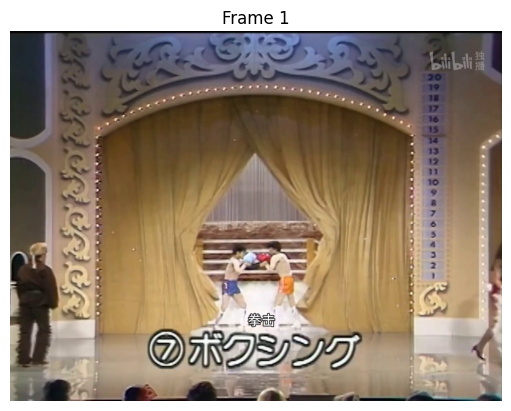

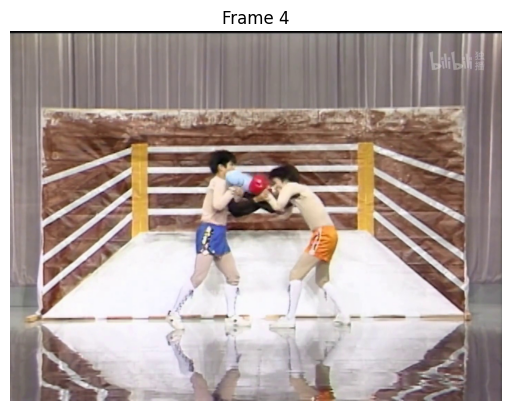

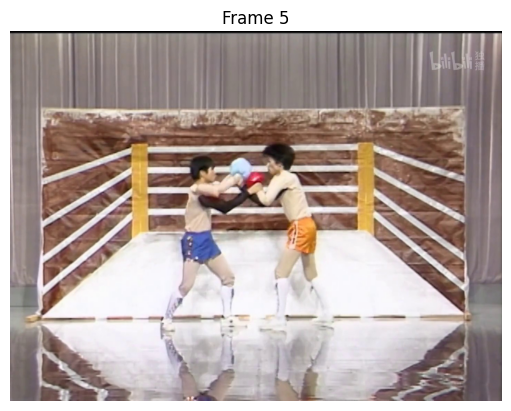

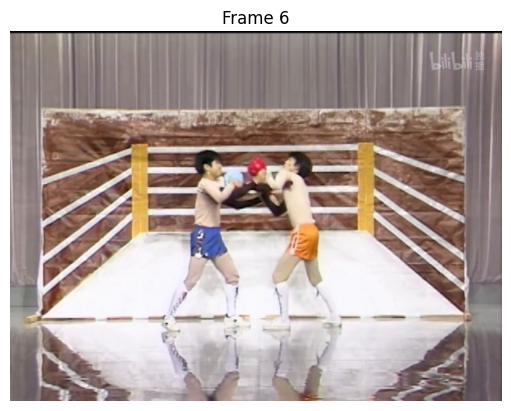

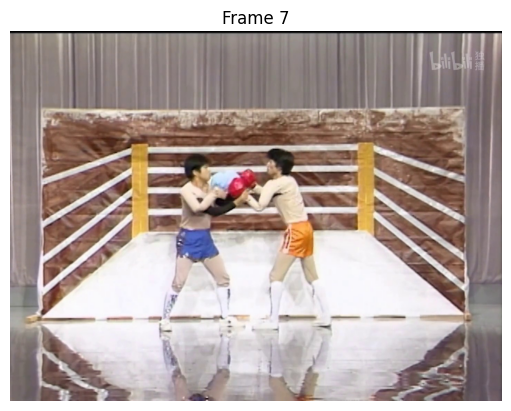

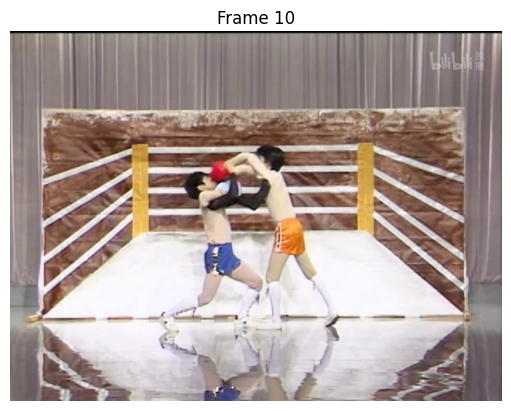

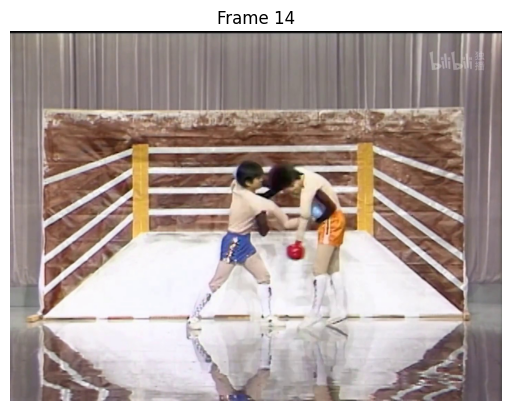

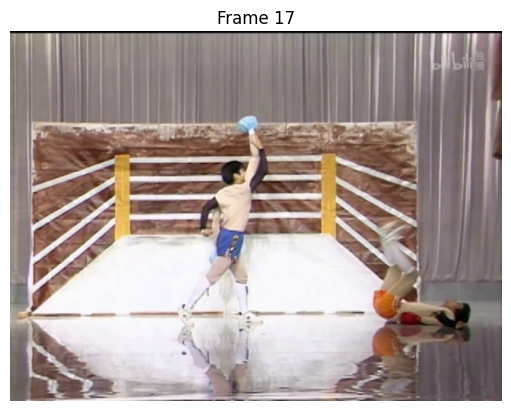

In [17]:
import base64
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image

video = cv2.VideoCapture(complex_question[rnd].get('video_path'))
base64Frames = []

while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()

total_frames = len(base64Frames)  # 获取列表总长度
interval = total_frames // 16  # 计算间隔

# 使用切片操作抽取帧
selected_frames = base64Frames[::interval]

# 可视化显示抽取的帧
for i, frame_data in enumerate(selected_frames):
    image_data = base64.b64decode(frame_data)
    image = Image.open(BytesIO(image_data))
    plt.imshow(image)
    plt.title(f"Frame {i+1}")
    plt.axis('off')
    plt.show()

In [27]:
chatbot.reset()
ret = agent.run(prompt)
print(ret)

set num_beams: 1
set temperature: 1.0


> Entering new AgentExecutor chain...
Action:
```
{
  "action": "video_llama Video Action Recognizer",
  "action_input": {
    "video_path": "/mnt/xuyibo/MVBench/video/perception/videos/video_5650.mp4",
    "question": "What actions does the person perform in the video?"
  }
}
```/mnt/xuyibo/MVBench/video/perception/videos/video_5650.mp4

Observation: The person in the video is seen sitting on the floor with a bottle of lotion on her lap. She seems to be trying to open the lotion and apply it to her hands. She also has a bottle of shampoo and a towel nearby.
Thought:The previous action used the Video Action Recognizer tool to identify the actions performed by the person in the video. The observation indicates that the person is sitting on the floor trying to open a lotion bottle and apply it to her hands. There is no mention of an electric device being used or unplugged. To further investigate, I will use the Video Object Detector & Tracker tool 

In [19]:
vp = "/mnt/xuyibo/MVBench/video/star/Charades_v1_480/TOOYI.mp4"
qe = "Generate the code for the correct choice: \n" + """Question: What will the person do next?
Options:
(A) Close the box.
(B) Take the phone/camera.
(C) Put down the book.
(D) Throw the clothes."""
print(video_llama(vp, qe))

/mnt/xuyibo/MVBench/video/star/Charades_v1_480/TOOYI.mp4



In [20]:
print(complex_question[rnd].get('gt'))

(A) Each boxer controls his opponent’s gloves using his own hands.


In [21]:
example = {'video': '/mnt/xuyibo/MVBench/video/FunQA_test/test/test_creative/C_KT_21_8053_8120.mp4',
  'question': 'Question: What is the unique aspect that makes the video intriguing?\nOptions:\n(A) A man is narrating a travel story while actually traveling.\n(B) A man is acting like a detective solving a mystery.\n(C) A man is performing both roles of a news anchor and a thief.\n(D) A man is reporting on a sports event while playing the sport.',
  'gt': '(C) A man is performing both roles of a news anchor and a thief.'}
output = agent.run(f"Generate the code for the correct choice: \nThis is the video path: {example['video']} \n{example['question']}\n ")




> Entering new AgentExecutor chain...
Thought: To answer this question, I need to understand the content of the video. I will use the video_llama Video Classificator tool to get the category of the video, and the video_llama Video Action Recognizer tool to understand the actions performed in the video. 

Action:
```
{
  "action": "video_llama Video Classificator",
  "action_input": {
    "video_path": "/mnt/xuyibo/MVBench/video/FunQA_test/test/test_creative/C_KT_21_8053_8120.mp4",
    "question": "What is the category of this video?"
  }
}
```/mnt/xuyibo/MVBench/video/FunQA_test/test/test_creative/C_KT_21_8053_8120.mp4

Observation: This video is a scene of a man in a play about a king and his friends playing boxing with gloves in a room.
Thought:The category of the video suggests a man is involved in a play about a king and his friends playing boxing with gloves in a room. This doesn't directly match any of the options, but it might be related to option (D) where a man is reporting 


Observation: I can see the TV screen on stage and the TV set on the stage in multiple instances. I can also see a large TV on the stage, and the stage itself is visible.
Thought:The object detection tool identified a TV screen and a TV set on stage, which could be used for reporting. This supports the idea that the man could be reporting on the sports event while playing the sport, as suggested in option (D). Given the information from the video category, action recognition, and object detection, I am confident that option (D) is the correct answer. 

Action:
```
{
  "action": "Final Answer",
  "action_input": "(D) A man is reporting on a sports event while playing the sport."
}
```

> Finished chain.


In [22]:
output

'(D) A man is reporting on a sports event while playing the sport.'